# Steel fracture detection

#### ***Problem***
Image segmentation problem - there are 4 classes of different fractures, each of which contain very irregular shapes. The task is to locate them.

#### ***Solution***
UNet model that takes image as the input and 4-channel mask as the label. Each mask has the same dimensions as the image, but only 1 channel (e.g. 256x2000x1) that represents fracture of a specific class. This way we can simultaneously model segmentations of all classes in the same label.

#### ***Models***
- UNet with ResNet50 base (4-channel mask), Dice loss
- UNet with ResNet50 base (1-channel mask), Dice loss

#### ***Results and learnings***
Sorry, no metrics yet! 
- It seems pretty easy to get an ok solution (visually) with out-of-the-box models.
- The models are really slow and it was pretty difficult to find a working architecture-loss combo.
- Pre-processing was nasty.


## **Teaser**
![alt text](https://i.imgur.com/xCVtZwk.png)

# Download data

In [0]:
keys = eval(open('/content/kaggle.json', 'r').read())

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

import os
os.environ['KAGGLE_USERNAME'] = keys["username"]  
os.environ['KAGGLE_KEY'] = keys["key"]
!mkdir data
!kaggle competitions download -c severstal-steel-defect-detection -p /content/data

# Install and load requirements

In [0]:
!pip uninstall tensorflow
!pip install tensorflow-gpu

In [0]:
!pip install DLHelper

In [0]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from DLHelper.image import Augmentor, Resizer
from sklearn.model_selection import train_test_split

In [6]:
tf.__version__

'2.1.0'

# Prepare data

### Unzip and move

In [0]:
!unzip /content/data/severstal-steel-defect-detection.zip -d /content/data/
!mv /content/data/severstal-steel-defect-detection.zip /content/

# EDA

Preprocessing will take quite a while - masks are multi-class and stored in strings...

In [0]:
data = pd.read_csv('data/train.csv')

In [12]:
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [13]:
print(f"Unique images with labels: {data.ImageId.nunique()}, total images with labels: {data.shape[0]}")
print(f"Total images (with and without labels): {len(os.listdir('data/train_images/'))}")

Unique images with labels: 6666, total images with labels: 7095
Total images (with and without labels): 12568


In [14]:
print(f"Number of classes: {data.ClassId.nunique()}")

Number of classes: 4


In [42]:
data.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

# Preprocess 

### Pivot data set to have 4 classes for each image (even if they have no data for the mask).

In [15]:
data_transformed = data.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
data_transformed.head()

ClassId,1,2,3,4
ImageId,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN


In [0]:
# Number of non-missing labels should be equal to total labels in the initial DF
assert len(data.ImageId) == data_transformed.notna().sum().sum()

In [17]:
data_transformed.notna().sum().sum()

7095

### Fill NA's with string zeros

In [0]:
data_transformed = data_transformed.fillna("0")

### Convert masks from a long string to 256*1000 numpy arrays (with 0/1 values)

In [0]:
# Converter for arrays
def label_mask(label):
  if label != "0":
    mask = np.zeros((256*1600), dtype=np.uint8)
    label = tf.strings.split(label, " ")
    positions = map(int, label[0::2])
    length = map(int, label[1::2])
    for pos, le in zip(positions, length):
        mask[pos-1:pos+le-1] = 1
    mask = mask.reshape((256,1600), order='F')
    return mask
  else:
    return np.zeros((256, 1600), dtype=np.uint8)

In [0]:
# Wrapper for TF Data
def label_mask_tf(label):
  return tf.py_function(label_mask, label, Tout=tf.float32)

### Visualize masks

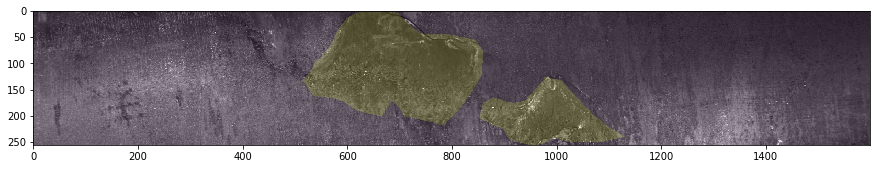

In [22]:
import matplotlib.pyplot as plt

def overlay_image(row_num):
  data_img_1 = label_mask(data["EncodedPixels"].iloc[row_num])
  data_img_2 = plt.imread(str("/content/data/train_images/") + data["ImageId"].iloc[row_num]) / 255

  fig, ax = plt.subplots(1,1, figsize=(15,3))
  ax.imshow(data_img_2)
  ax.imshow(data_img_1, alpha=0.15)
  plt.show()

overlay_image(3)

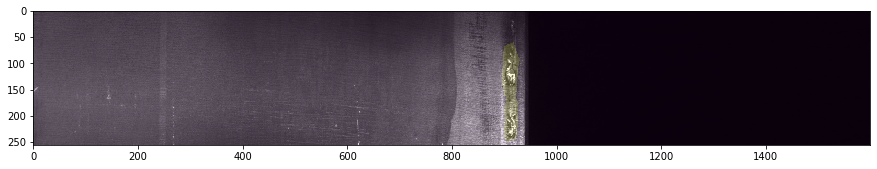

In [23]:
overlay_image(4)

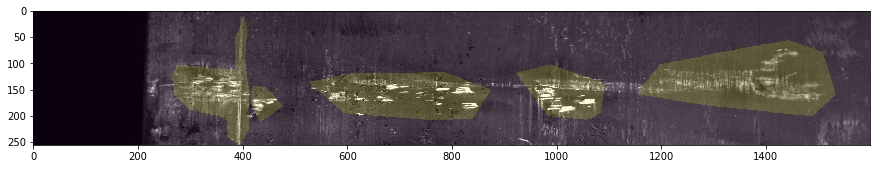

In [24]:
overlay_image(512)

### Preprocessing pipeline

- Image reader (+ scaler)
- Augmentor
- Data generator (input = 3-channel image, label = 4-channel mask)

BEWARE: image size is currently hardcoded, check for input-output consistency

In [0]:
# Image reader
def img_reader(filename):
    image = tf.image.decode_jpeg(tf.io.read_file("/content/data/train_images/"+filename), channels=3)
    image = tf.image.resize(image, (64,256))
    image = tf.cast(image, tf.float32)
    if image.shape[2] == 1:
        image = tf.reshape(image, (image.shape[0], image.shape[1]))
    image /= 255
    return image

In [0]:
# Augmentor
augmentation_v1 = Augmentor(brightness=(0.5,0.2), contrast=(0.5,0.2), hue=(0.5,0.1))

In [0]:
# Output resizer
resizer_out = Resizer((64,256,4), resize = "stretch")

In [0]:
# Data gen
def data_generator(dataframe, batch_size):
  data_image = tf.data.Dataset.from_tensor_slices(np.array(dataframe.index.values))
  data_image = data_image.map(lambda x: img_reader(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data_image = data_image.map(augmentation_v1, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  data_mask_0 = tf.data.Dataset.from_tensor_slices(dataframe.iloc[:,0])
  data_mask_1 = tf.data.Dataset.from_tensor_slices(dataframe.iloc[:,1])
  data_mask_2 = tf.data.Dataset.from_tensor_slices(dataframe.iloc[:,2])
  data_mask_3 = tf.data.Dataset.from_tensor_slices(dataframe.iloc[:,3])
  data_label = tf.data.Dataset.zip((data_mask_0, data_mask_1, data_mask_2, data_mask_3))
  data_label = data_label.map(lambda w,x,y,z: (label_mask_tf([w]), label_mask_tf([x]),
                                   label_mask_tf([y]), label_mask_tf([z])),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data_label = data_label.map(lambda d1, d2, d3, d4: tf.stack([d1, d2, d3, d4],-1),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data_label = data_label.map(lambda x: tf.reshape(x, [256,1600,4]), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data_label = data_label.map(lambda x: resizer_out(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data = tf.data.Dataset.zip((data_image, data_label))
  
  data = data.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [30]:
for x,y in data_generator(data_transformed, 32).take(1):
  print("Check input/label shapes and min/max values")
  print(x.shape, y.shape, x.numpy().min(), x.numpy().max(), 
        y.numpy().min(), y.numpy().max())

(32, 64, 256, 3) (32, 64, 256, 4) 0.0 1.0 0.0 1.0


### Split data and visualize augmented generator results

In [0]:
train_df, val_df = train_test_split(data_transformed, test_size=0.1)

In [0]:
train_ds, val_ds = data_generator(train_df, 32), data_generator(val_df, 32)

AxesImage(54,36;334.8x217.44)


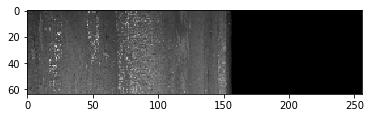

In [33]:
for x,y in train_ds.take(1):
  print(plt.imshow(x[0].numpy()))

# Segmentation model - UNET with ResNet50 basis

Fail: after trying several things (and training the best one for a longer time below), the results are bad.

In [0]:
# !pip install segmentation_models
import segmentation_models as sm
from segmentation_models.losses import DiceLoss, JaccardLoss

In [35]:
# Change framework
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [36]:
# Define model
model = sm.Unet('resnet50', classes=4, activation='sigmoid')

94593024/94592056 [==============================] - 1s 0us/step


In [0]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=DiceLoss(), # Some fancy segmentation loss
    metrics=[
      "accuracy"
    ],
)

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [45]:
model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=len(train_df)//32,
    validation_steps=len(val_df)//32,
)

Train for 187 steps, validate for 20 steps
Epoch 1/15
187/187 [==============================] - 680s 4s/step - loss: 0.6117 - accuracy: 0.0783 - val_loss: 0.6663 - val_accuracy: 0.0794
Epoch 2/15
187/187 [==============================] - 680s 4s/step - loss: 0.5952 - accuracy: 0.3717 - val_loss: 0.6436 - val_accuracy: 0.6523
Epoch 3/15
187/187 [==============================] - 692s 4s/step - loss: 0.5373 - accuracy: 0.2830 - val_loss: 0.6482 - val_accuracy: 0.0811
Epoch 4/15
187/187 [==============================] - 707s 4s/step - loss: 0.5085 - accuracy: 0.0931 - val_loss: 0.5837 - val_accuracy: 0.0731
Epoch 5/15
187/187 [==============================] - 691s 4s/step - loss: 0.4783 - accuracy: 0.0899 - val_loss: 0.5748 - val_accuracy: 0.0715
Epoch 6/15
187/187 [==============================] - 686s 4s/step - loss: 0.4462 - accuracy: 0.1007 - val_loss: 0.5511 - val_accuracy: 0.0695
Epoch 7/15
187/187 [==============================] - 685s 4s/step - loss: 0.4415 - accuracy: 0.095

In [0]:
def show_results(img_num=None, thresh=0.5):
  for x,y in val_ds.take(1):
    if img_num == None:
      pick = np.random.randint(0,31)
    else:
      pick = img_num
    image = x[pick, ...]
    mask = y[pick, ..., :3]
    prediction = (model.predict(x)[pick, ..., :3] > thresh).astype(np.float32)
  fig, ax = plt.subplots(2,1, figsize=(15,10), sharex='col', sharey='row')
  ax[0].set_title("Real input")
  ax[0].imshow(image)
  ax[0].imshow(mask, alpha=0.3, cmap="Reds")
  ax[1].set_title("Prediction")
  ax[1].imshow(image)
  ax[1].imshow(prediction, alpha=0.3, cmap="Blues")


Woops, wrong class predicted!


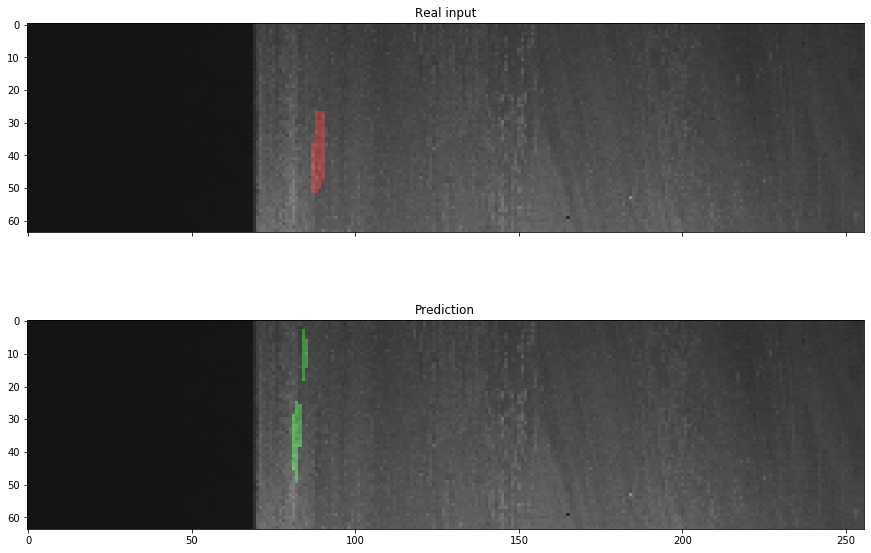

In [184]:
show_results(7, 0.5)
print("Woops, wrong class predicted!")

This seems pretty good.


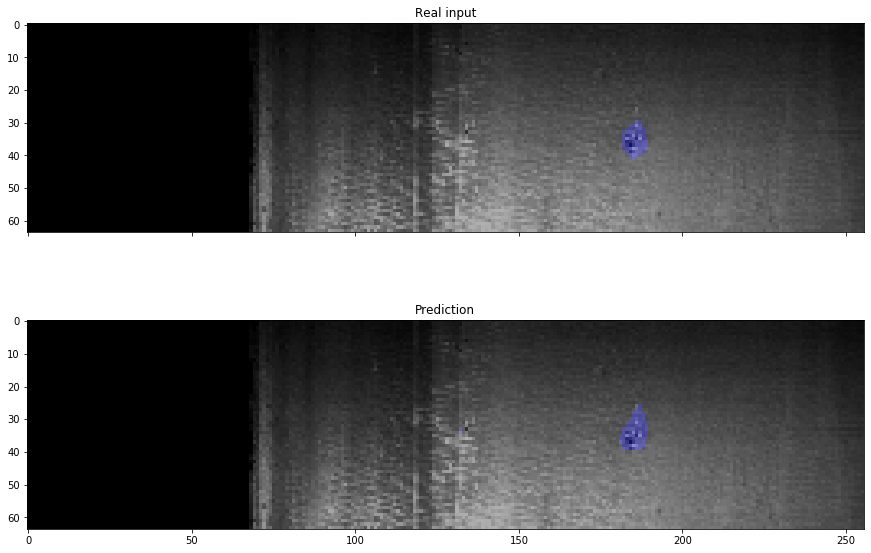

In [185]:
show_results(30, 0.3)
print("This seems pretty good.")

This seems ok too.


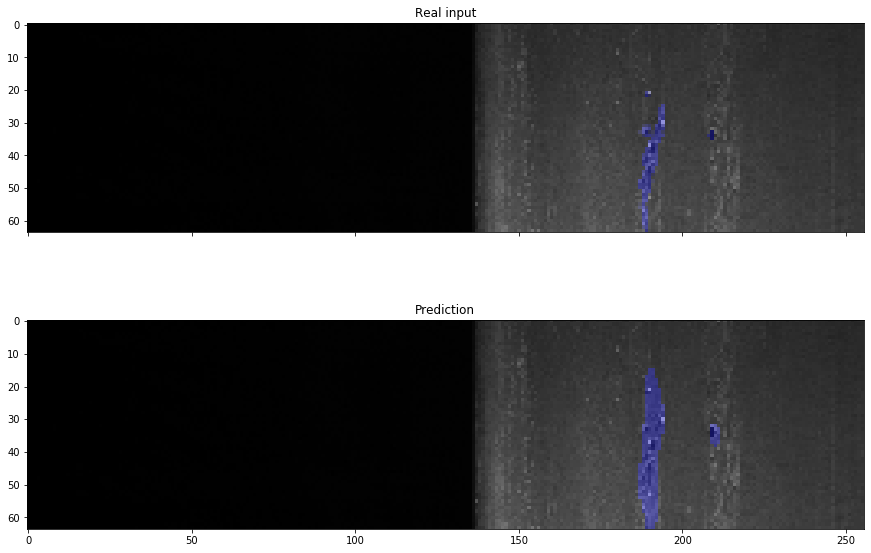

In [187]:
show_results(31, 0.3)
print("This seems ok too.")

Meh.


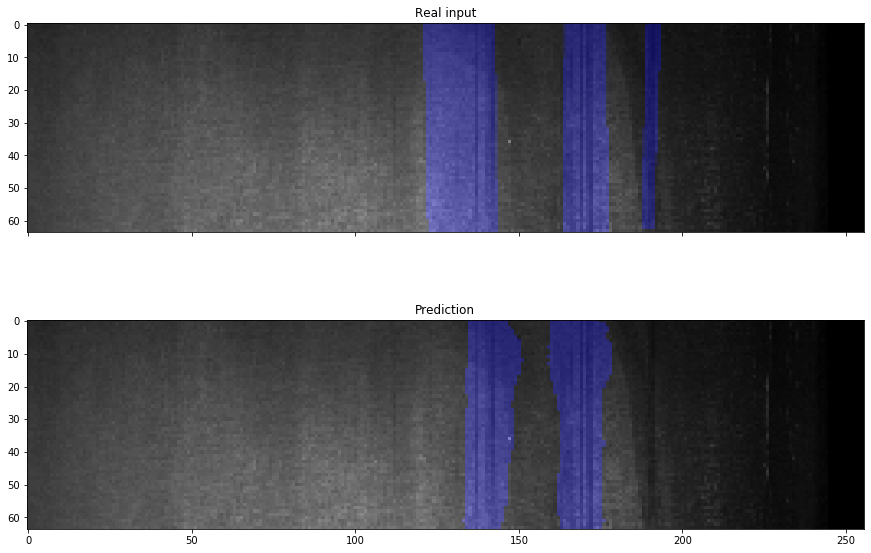

In [192]:
show_results(13, 0.3)
print("Meh.")

# Ok, let's just try 1 channel output

In [0]:
# Keep 3rd class (the most frequent in images)
data_transformed_1class = data_transformed.iloc[:,2]

In [0]:
# Data gen for 1-channel mask
resizer_out = Resizer((64,256,1), resize = "stretch")

def data_generator(dataframe, batch_size):
  data_image = tf.data.Dataset.from_tensor_slices(np.array(dataframe.index.values))
  data_image = data_image.map(lambda x: img_reader(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # No augmentation for performance reasons
  # data_image = data_image.map(augmentation_v1, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  data_label = tf.data.Dataset.from_tensor_slices(dataframe)
  data_label = data_label.map(lambda x: label_mask_tf([x]))
  data_label = data_label.map(lambda x: tf.reshape(x, [256,1600,1]), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data_label = data_label.map(lambda x: resizer_out(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data = tf.data.Dataset.zip((data_image, data_label))
  
  data = data.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [111]:
for x,y in data_generator(data_transformed_1class, 32).take(1):
  print("Check input/label shapes and min/max values")
  print(x.shape, y.shape, x.numpy().min(), x.numpy().max(), 
        y.numpy().min(), y.numpy().max())

Check input/label shapes and min/max values
(32, 64, 256, 3) (32, 64, 256, 1) 0.0 1.0 0.0 1.0


In [0]:
train_df_1class, val_df_1class = train_test_split(data_transformed_1class, test_size=0.1)
train_ds_1class, val_ds_1class = data_generator(train_df_1class, 32), data_generator(val_df_1class, 32)

In [0]:
# Define model
model_1class = sm.Unet('resnet50', classes=1, activation='sigmoid')

# Compile
model_1class.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=DiceLoss(), # Some fancy segmentation loss
    metrics=[
      "accuracy"
    ],
)

In [114]:
model_1class.fit(
    x=train_ds_1class,
    validation_data=val_ds_1class,
    epochs=15,
    steps_per_epoch=len(train_df)//32,
    validation_steps=len(val_df)//32,
)

Train for 187 steps, validate for 20 steps
Epoch 1/15
187/187 [==============================] - 397s 2s/step - loss: 0.7810 - accuracy: 0.8282 - val_loss: 0.9405 - val_accuracy: 0.9450
Epoch 2/15
187/187 [==============================] - 410s 2s/step - loss: 0.5771 - accuracy: 0.9442 - val_loss: 0.9726 - val_accuracy: 0.9450
Epoch 3/15
187/187 [==============================] - 422s 2s/step - loss: 0.4292 - accuracy: 0.9622 - val_loss: 0.9870 - val_accuracy: 0.9450
Epoch 4/15
187/187 [==============================] - 439s 2s/step - loss: 0.3533 - accuracy: 0.9685 - val_loss: 0.9809 - val_accuracy: 0.9452
Epoch 5/15
187/187 [==============================] - 428s 2s/step - loss: 0.3123 - accuracy: 0.9718 - val_loss: 0.6597 - val_accuracy: 0.9553
Epoch 6/15
187/187 [==============================] - 427s 2s/step - loss: 0.2814 - accuracy: 0.9743 - val_loss: 0.4485 - val_accuracy: 0.9636
Epoch 7/15
187/187 [==============================] - 431s 2s/step - loss: 0.2609 - accuracy: 0.976

KeyboardInterrupt: ignored

In [0]:
def show_results(img_num=None, thresh=0.5):
  for x,y in val_ds_1class.take(1):
    if img_num == None:
      pick = np.random.randint(0,31)
    else:
      pick = img_num
    image = x[pick, ...]
    mask = y[pick, ...]
    prediction = (model_1class.predict(x)[pick, ...] > thresh).astype(np.float32)
  fig, ax = plt.subplots(2,1, figsize=(15,10), sharex='col', sharey='row')
  ax[0].set_title("Real mask")
  ax[0].imshow(image)
  ax[0].imshow(np.stack([mask, mask, mask], axis=2).squeeze(), alpha=0.4, cmap="Reds")
  ax[1].set_title("Prediction")
  ax[1].imshow(image)
  ax[1].imshow(np.stack([prediction, prediction, prediction], axis=2).squeeze(), alpha=0.4, cmap="Blues")


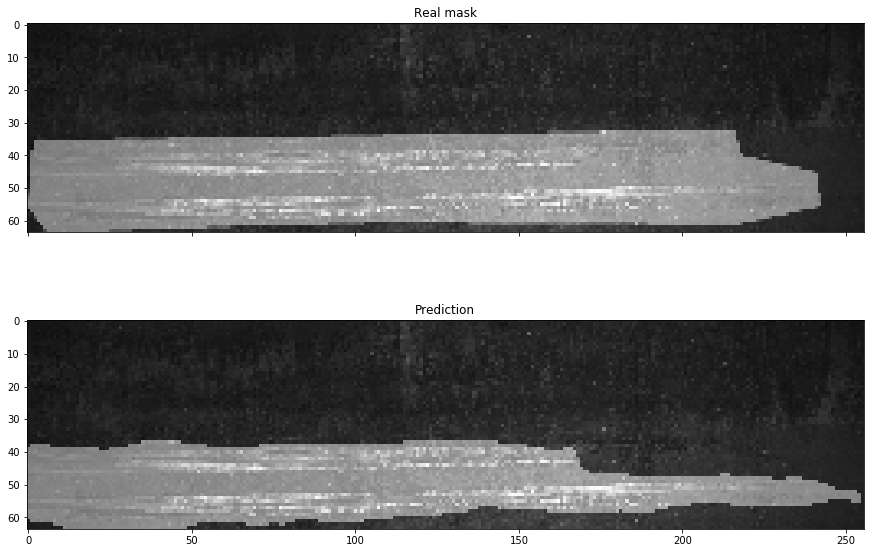

In [201]:
prediction = show_results(4, 0.1)

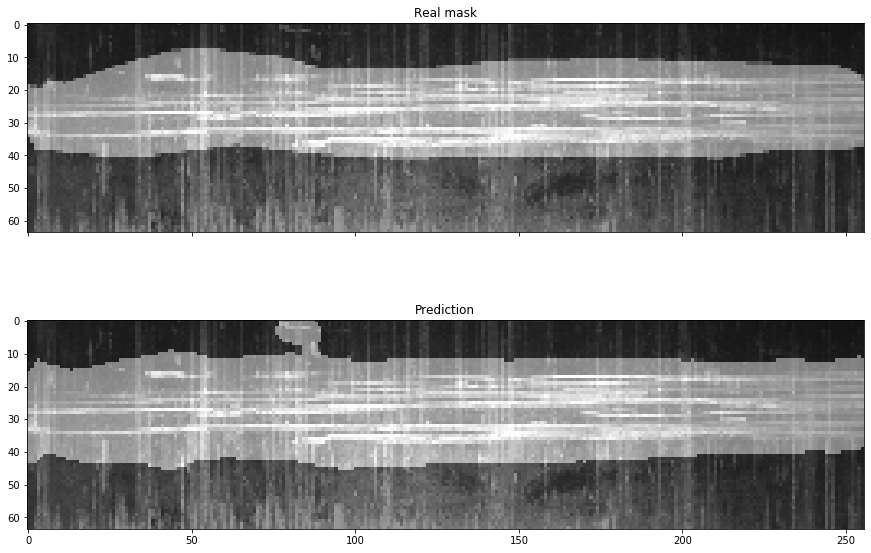

In [202]:
prediction = show_results(5, 0.1)

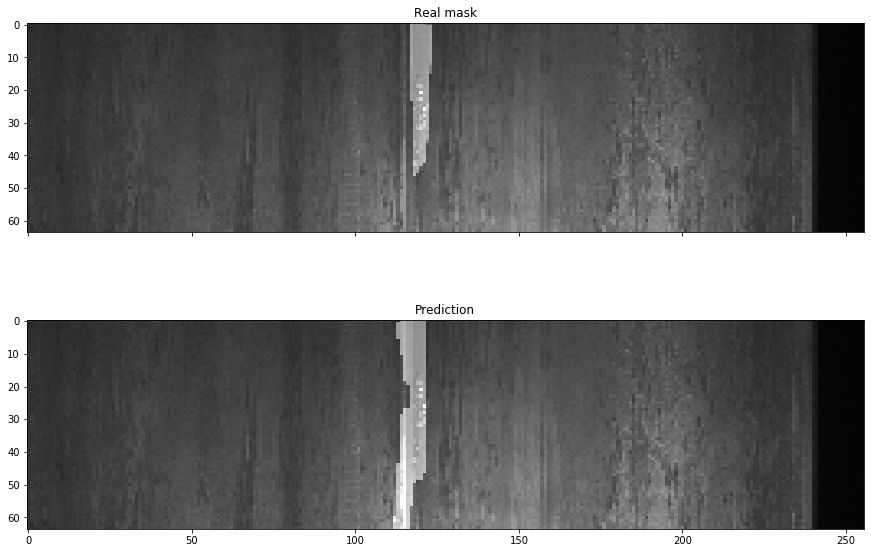

In [205]:
prediction = show_results(16, 0.5)

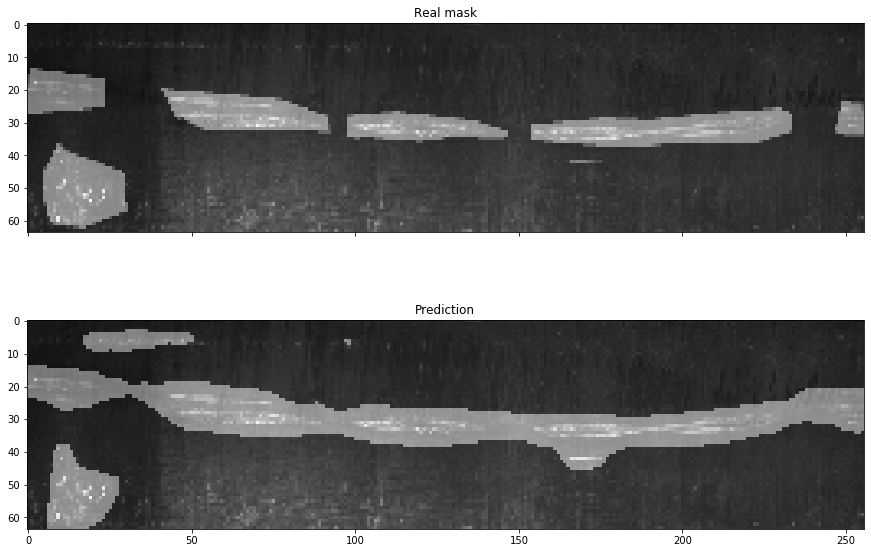

In [206]:
prediction = show_results(12, 0.1)